# Sales Forecasting (Top-10 Products)

Goal:
- Clean retail transactions
- Compute daily revenue per product
- Select top-10 products by total revenue
- Forecast next 30 days using Prophet for each product
- Produce an output CSV used by dashboard/chatbot/inventory


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
DATA_PATH = r"..\..\data\raw\sales_forecasting\online_retail_II.csv"  # adjust path if needed
df = pd.read_csv(DATA_PATH)
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [14]:
# Convert date
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Remove negative values
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

# Create sales value
df["Sales"] = df["Quantity"] * df["Price"]

df.shape


(1041670, 9)

### why daily?
Daily forecasting provides a flexible base that can be aggregated into weekly or monthly forecasts without retraining the model

In [15]:
top10 = (
    df.groupby("StockCode")["Sales"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
      .tolist()
)

top10

['22423',
 'M',
 'DOT',
 '85123A',
 '85099B',
 '23843',
 '47566',
 '84879',
 'POST',
 '22086']

In [16]:
df_top = df[df["StockCode"].isin(top10)].copy()

daily_prod = (
    df_top.groupby([df_top["InvoiceDate"].dt.date, "StockCode"])["Sales"]
          .sum()
          .reset_index()
)

daily_prod.columns = ["date", "product_id", "sales"]
daily_prod.head()

,date,product_id,sales
0,2009-12-01,22086,1327.37
1,2009-12-01,47566,27.90
2,2009-12-01,84879,1919.28
3,2009-12-01,85099B,326.85
4,2009-12-01,85123A,702.42


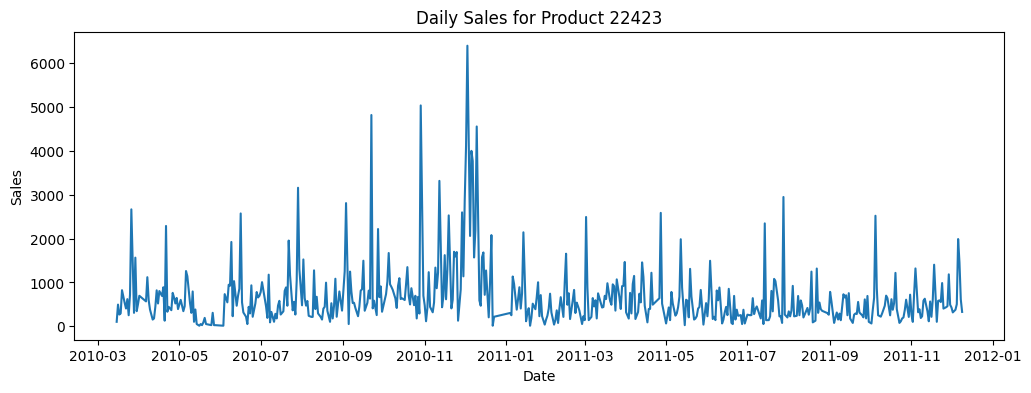

In [17]:
prod = top10[0]
one = daily_prod[daily_prod["product_id"] == prod]

plt.figure(figsize=(12,4))
plt.plot(one["date"], one["sales"])
plt.title(f"Daily Sales for Product {prod}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

### Why Prophet?
project goal is: Decision support, not statistical modeling.

So Prophet is the right choice as it's
```
    1.Easy to explain	
    2.Handles seasonality automatically
    3.Business-friendly	
    4.Robust to missing data	
    5.Designed for forecasting
```

05:57:40 - cmdstanpy - INFO - Chain [1] start processing
05:57:40 - cmdstanpy - INFO - Chain [1] done processing


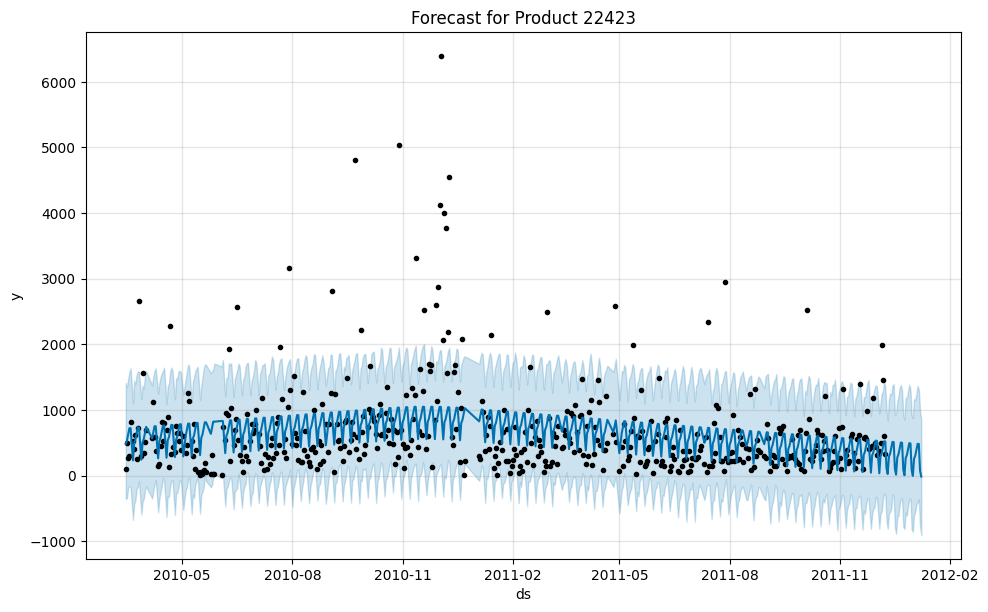

In [18]:
from prophet import Prophet

prophet_df = one.rename(columns={"date":"ds", "sales":"y"})
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

m = Prophet()
m.fit(prophet_df)

future = m.make_future_dataframe(periods=30)
fc = m.predict(future)

m.plot(fc)
plt.title(f"Forecast for Product {prod}")
plt.show()


In [26]:
all_forecasts = []

for prod in top10:
    sub = daily_prod[daily_prod["product_id"] == prod].copy()
    sub = sub.rename(columns={"date":"ds","sales":"y"})
    sub["ds"] = pd.to_datetime(sub["ds"])

    # Skip products with too few days (safety)
    if sub.shape[0] < 14:
        continue

    m = Prophet()
    m.fit(sub)

    future = m.make_future_dataframe(periods=30)
    fc = m.predict(future)[["ds","yhat"]].copy()
    fc["product_id"] = prod

    all_forecasts.append(fc)

forecast_df = pd.concat(all_forecasts, ignore_index=True)
forecast_df.head()


06:01:57 - cmdstanpy - INFO - Chain [1] start processing
06:01:57 - cmdstanpy - INFO - Chain [1] done processing
06:01:57 - cmdstanpy - INFO - Chain [1] start processing
06:01:57 - cmdstanpy - INFO - Chain [1] done processing
06:01:58 - cmdstanpy - INFO - Chain [1] start processing
06:01:58 - cmdstanpy - INFO - Chain [1] done processing
06:01:58 - cmdstanpy - INFO - Chain [1] start processing
06:01:58 - cmdstanpy - INFO - Chain [1] done processing
06:01:58 - cmdstanpy - INFO - Chain [1] start processing
06:01:58 - cmdstanpy - INFO - Chain [1] done processing
06:01:58 - cmdstanpy - INFO - Chain [1] start processing
06:01:58 - cmdstanpy - INFO - Chain [1] done processing
06:01:59 - cmdstanpy - INFO - Chain [1] start processing
06:01:59 - cmdstanpy - INFO - Chain [1] done processing
06:01:59 - cmdstanpy - INFO - Chain [1] start processing
06:01:59 - cmdstanpy - INFO - Chain [1] done processing
06:01:59 - cmdstanpy - INFO - Chain [1] start processing
06:01:59 - cmdstanpy - INFO - Chain [1]

,ds,yhat,product_id
0,2010-03-15,485.989451,22423
1,2010-03-16,536.205086,22423
2,2010-03-17,631.498404,22423
3,2010-03-18,722.597761,22423
4,2010-03-19,721.975664,22423


# Model Evaluation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load forecast output
df = pd.read_csv(r"../../data/outputs/sales_forecast.csv")
df["date"] = pd.to_datetime(df["date"])


In [3]:
product_id = df["product_id"].unique()[0]  # pick first top product
prod_df = df[df["product_id"] == product_id].copy()


In [4]:
weekly = (
    prod_df
    .groupby(prod_df["date"].dt.to_period("W"))
    .agg({
        "actual_sales": "sum",
        "predicted_sales": "sum"
    })
    .reset_index()
)

weekly["date"] = weekly["date"].dt.to_timestamp()
weekly.head()


,date,actual_sales,predicted_sales
0,2009-11-30,5604.38,3808.865311
1,2009-12-07,2143.03,3932.196801
2,2009-12-14,2014.18,2413.570319
3,2009-12-21,413.67,296.377877
4,2010-01-11,101.61,17.560283


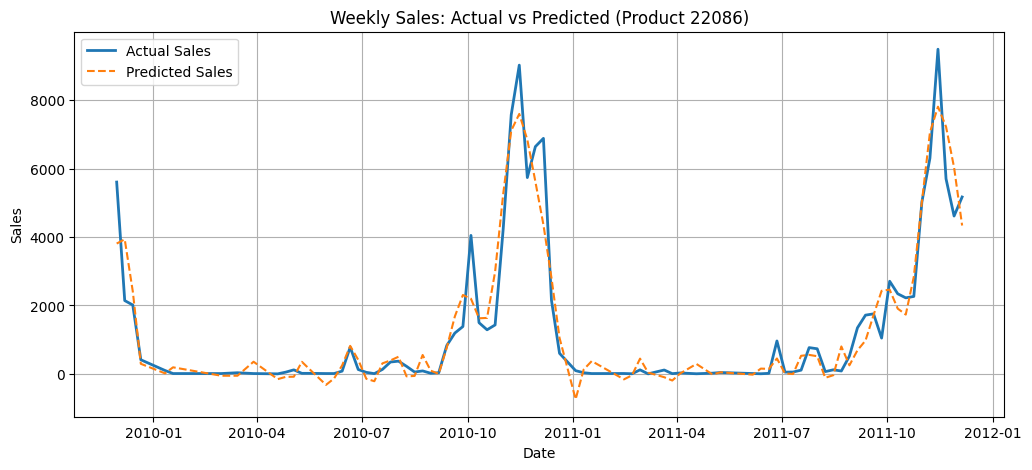

In [5]:
plt.figure(figsize=(12,5))

plt.plot(weekly["date"], weekly["actual_sales"], label="Actual Sales", linewidth=2)
plt.plot(weekly["date"], weekly["predicted_sales"], label="Predicted Sales", linestyle="--")

plt.title(f"Weekly Sales: Actual vs Predicted (Product {product_id})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)

plt.show()


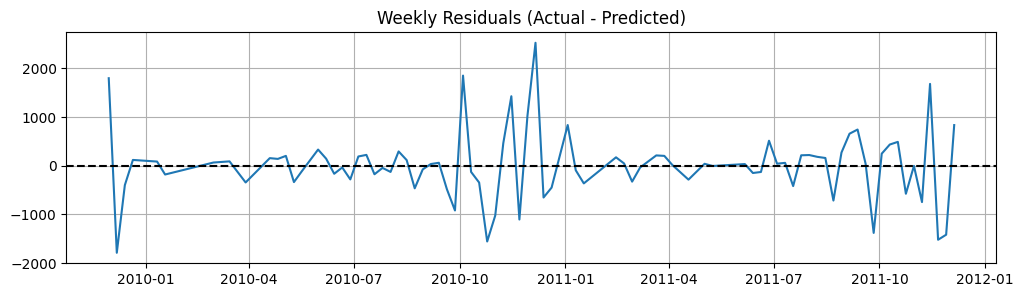

In [6]:
weekly["residual"] = weekly["actual_sales"] - weekly["predicted_sales"]

plt.figure(figsize=(12,3))
plt.plot(weekly["date"], weekly["residual"])
plt.title("Weekly Residuals (Actual - Predicted)")
plt.axhline(0, color="black", linestyle="--")
plt.grid(True)
plt.show()
